# Information
$Writer: Junhyuck\ Woo$ <br>
$Std.ID: 20145337$<br>
$Assignment10:\ Multi-label\ classification\ using\ neural\ networks\ with\ a\ regularization$<br>
$Deadline: June\ 4, 2020$
<hr>

# Library

In [0]:
import matplotlib.pyplot as plt; import numpy as np; import time

# Data

In [0]:
file_data   = "/content/drive/My Drive/Spring|2020/Machine_Learning/CAU-MachineLearning/Assignment10/mnist.csv"
handle_file = open(file_data, "r")
data        = handle_file.readlines()
handle_file.close()

size_row    = 28    # height of the image
size_col    = 28    # width of the image

num_image   = len(data)
count       = 0     # count for the number of images

#
# normalize the values of the input data to be [0, 1]
#
def normalize(data):

    data_normalized = (data - min(data)) / (max(data) - min(data))

    return(data_normalized)

#
# example of distance function between two vectors x and y
#
def distance(x, y):

    d = (x - y) ** 2
    s = np.sum(d)
    # r = np.sqrt(s)

    return(s)

#
# make a matrix each column of which represents an images in a vector form
#
list_image  = np.empty((size_row * size_col, num_image), dtype=float)
list_label  = np.empty(num_image, dtype=int)

for line in data:

    line_data   = line.split(',')
    label       = line_data[0]
    im_vector   = np.asfarray(line_data[1:])
    im_vector   = normalize(im_vector)

    list_label[count]       = label
    list_image[:, count]    = im_vector

    count += 1

# Split data as train one and test one
Train: [1~1000] <br>
Test: [1001 ~ 10000]

In [0]:
train_m = 6000
test_m = num_image - train_m
train_image = list_image[:,:train_m]
test_image = list_image[:, train_m:]
train_label = list_label[:train_m]
test_label = list_label[train_m:]

# Neural Network Architecture
* input layer : 784 (+ a bias)
* first hidden layer : 196 (+ a bias)
* second hidden layer : 49 (+ a bias)
* output layer : 10

In [0]:
mean = 0
sigma = 1
node_num = [784, 196, 49, 10]
layer_num = len(node_num)

network = []
node_t = []
node = []
for i, v in enumerate(node_num[:-1]):
    network.append(np.random.normal(mean, sigma, (node_num[i+1], node_num[i]+1)))
    node_t.append(np.zeros((node_num[i]+1, test_m)))
    node.append(np.zeros((node_num[i]+1, train_m)))
node_t.append(np.zeros((node_num[-1], test_m)))
node.append(np.zeros((node_num[-1], train_m)))
node_t = np.array(node_t)
node = np.array(node)

# Sigmoid Function (= activation function)
$\sigma(z) = \frac{1}{1 + \exp(-z)}$<br>
$\sigma(z)' = \sigma(z)(1 - \sigma(z))$

In [0]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

def sigmoid_(z_):
    return z_*(1-z_)

# Objective Function
$J(\theta) = \frac{1}{m} \sum_{i=1}^m \sum_{k=0}^{9}( - l^{(i)}_k \log( h^{(i)}_k ) - (1 - l^{(i)}_k) \log(1 - h^{(i)}_k) )$<br>
$\theta = (u, v, w)$

In [0]:
def one_hot(l):
    new_label = np.zeros((10,len(l)))
    for i, v in enumerate(l):
        new_label[v][i] = 1
    return new_label
    
def j_func(h, label, size):
    loss_list = -label*np.log(h) - (1 - label)*np.log(1-h)
    loss = np.sum(loss_list)
    return (loss/size)

# Gradient Descent (Back-propagation)

In [0]:
def prop(model, nodes, bias, data):

    node = np.concatenate((bias, data), axis=0)
    nodes[0] = node
    
    for i, v in enumerate(node_num[1:]):
        node = np.dot(model[i], nodes[i])
        node = sigmoid(node)
        if v == node_num[-1]:
            nodes[i+1] = node
        else:
            nodes[i+1] = np.concatenate((bias, node), axis=0)

    return nodes

def backprop(model, node, l, size):
    alpha = 0.3
    new_model = model

    tmp = (node[layer_num-1] - l)/size
    new_model[layer_num-2] = new_model[layer_num-2] - alpha*np.dot(tmp, node[layer_num-2].T)

    for i, v in enumerate(range(layer_num-2, 0, -1)):
        tmp = np.dot(new_model[v].T[1:,:], tmp) * sigmoid_(node[v][1:])
        new_model[v-1] = new_model[v-1] - alpha * np.dot(tmp, node[v-1].T)

    return new_model

# Optimization

In [0]:
# Varibales
count = 1
accuracy_history = [[], []]
j = [0, 0]
j_old = 10
j_history = [[], []]
bias_train = np.array([np.ones(train_m)])
bias_test = np.array([np.ones(test_m)])
train_oh_label = one_hot(train_label)
test_oh_label = one_hot(test_label)

# Check the runtime
start = time.time()

while (abs(j_old - j[0]) > 0.002):
    # Reset the variables
    accuracy = [0, 0]
    
    # Update the Loss
    j_old = j[0]

    # Train
    # Forward propagation
    node = prop(network, node, bias_train, train_image)

    # Train Loss
    j[0] = j_func(node[3], train_oh_label, train_m)

    # Train Accuracy
    h_argmax = []
    for i, v in enumerate(node[3].T):
        h_argmax.append(np.argmax(v))
    accuracy[0] = np.sum(1*np.equal(h_argmax, train_label))

    # Test
    # Forward propagation
    node_t = prop(network, node_t, bias_test, test_image)

    # Test Loss
    j[1] = j_func(node_t[3], test_oh_label, test_m)
    
    # Test Accuracy
    h_t_argmax = []
    for i, v in enumerate(node_t[3].T):
        h_t_argmax.append(np.argmax(v))
    accuracy[1] = np.sum(1*np.equal(h_t_argmax, test_label))
    
    # Back-propagation
    network = backprop(network, node, train_oh_label, train_m)
      
    # Record the history
    accuracy_history[0].append((accuracy[0]*100 / len(h_argmax)))
    j_history[0].append(j[0])
    accuracy_history[1].append(accuracy[1]*100 / len(h_t_argmax))
    j_history[1].append(j[1])

    # Count Iteration
    count = count + 1
runtime = time.time() - start

# Check the convergence

In [9]:
print("Iteration: ", count)
print("Runtime: ", runtime)
print("Loss Diff: ", abs(j[0] - j_old))

Iteration:  296
Runtime:  109.50424599647522
Loss Diff:  0.0019988976774396594


# Check the history for display example

In [0]:
classified_ex = []
misclassified_ex = []
check_list = np.zeros(10)
for i, v in enumerate(h_t_argmax):
    if v==test_label[i]:
        if (len(classified_ex)==10):
            continue
        else:
            if (check_list[v]==0):
                classified_ex.append(i)
                check_list[v] = 1
            else:
                continue
    else:
        if (len(misclassified_ex)==10):
            continue
        else:
            misclassified_ex.append(i)
    if (len(classified_ex)==10) and (len(misclassified_ex)==10):
        break

___
#Result

# 1. Loss Curve

Text(0, 0.5, 'Error')

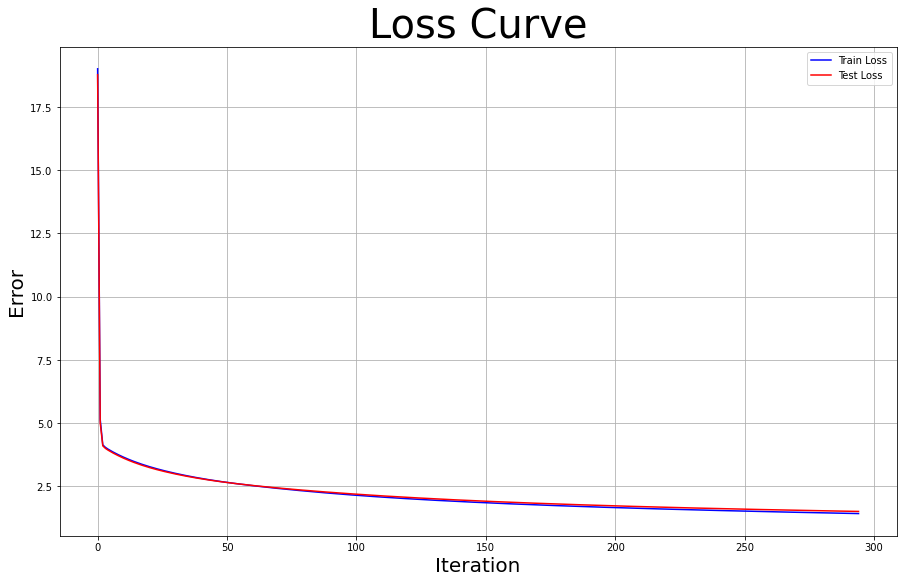

In [11]:
plt.figure(figsize=(15,9))
plt.plot(j_history[0], color='blue', label='Train Loss')
plt.plot(j_history[1], color='red', label='Test Loss')
plt.grid()
plt.legend()
plt.title('Loss Curve', fontsize=40)
plt.xlabel('Iteration', fontsize=20)
plt.ylabel('Error', fontsize=20)

# 2. Accuravy Curve

Text(0, 0.5, 'Accuracy')

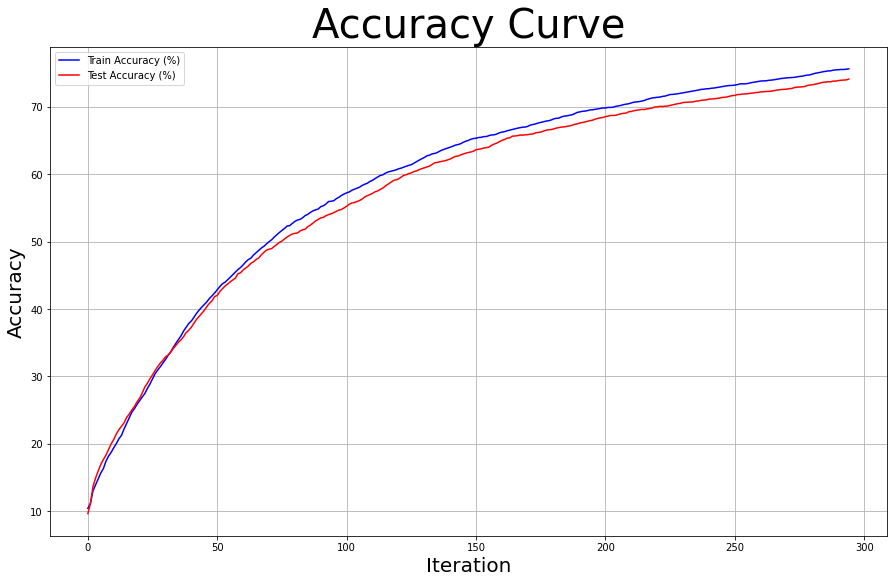

In [12]:
plt.figure(figsize=(15,9))
plt.plot(accuracy_history[0], color='blue', label='Train Accuracy (%)')
plt.plot(accuracy_history[1], color='red', label='Test Accuracy (%)')
plt.grid()
plt.legend()
plt.title('Accuracy Curve', fontsize=40)
plt.xlabel('Iteration', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)

# 3. Accuracy Value

In [13]:
print('Final Accuracy')
print('Train: %lf' %((accuracy[0]*100 / len(h_argmax))))
print('Test: %lf' %((accuracy[1]*100 / len(h_t_argmax))))

Final Accuracy
Train: 75.650000
Test: 74.125000


# 4. Classification Example
## 1. Correctly Classified Testing Image

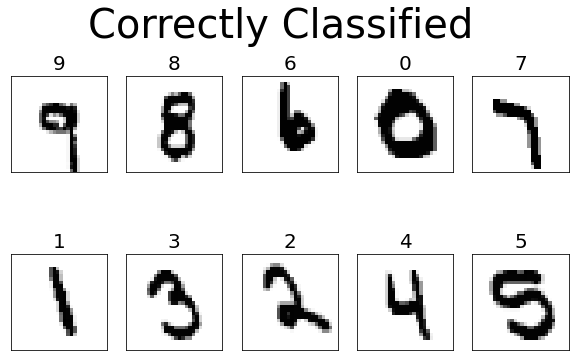

In [14]:
f1 = plt.figure(figsize=(10,6))
plt.suptitle("Correctly Classified", fontsize = 40)
for i in range(10):

    im_vector   = test_image[:, classified_ex[i]]
    im_matrix   = im_vector.reshape((size_row, size_col))

    plt.subplot(2, 5, i+1)
    plt.title(h_t_argmax[classified_ex[i]], fontsize=20)
    plt.imshow(im_matrix, cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)

plt.show()

## 2. Misclassified Testing Image

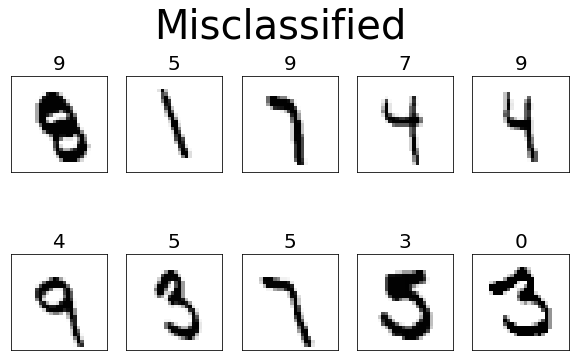

In [15]:
f1 = plt.figure(figsize=(10,6))
plt.suptitle("Misclassified", fontsize = 40)
for i in range(10):

    im_vector   = test_image[:, misclassified_ex[i]]
    im_matrix   = im_vector.reshape((size_row, size_col))

    plt.subplot(2, 5, i+1)
    plt.title(h_t_argmax[misclassified_ex[i]], fontsize=20)
    plt.imshow(im_matrix, cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)

plt.show()